# Application of POD to the harmonic oscillator

In this notebook we introduce the application of Proper Orthogonal Decomposition (POD) using an example proposed by Brunton and Kurtz in their book [Data Driven Science and Engineering](https://www.amazon.fr/Data-Driven-Science-Engineering-Learning-Dynamical/dp/1108422098). Original Matlab implementation is transformed in Julia code with a few adjustments.

Here we will need a few tools:
- `DifferentialEquations` to simulate the system dynamics from its ODE.
- `FFTW` to perform Fourier transforms to simulate system in modal space.
- `LinearAlgebra` to perform the SVD underlining the POD method.
- `Plots` to visualize our results and the decomposed modes from POD.
- `SpecialPolynomials` to compute some Hermite polynomials without coding them.

Backend `pyplot` has been chosen for graphics rendering.

In [1]:
using DifferentialEquations;
using FFTW;
using LinearAlgebra;
using Plots;
using SpecialPolynomials;

pyplot();

Quantum mechanical harmonic oscillator is described by the following PDE which must be solved for the amplitude $u$ given a potential $V$ and 

$$
i{}u_t + \frac{1}{2}u_{xx} - \frac{1}{2}V{}u = 0
$$

Applying a Fourier transform (and making use of its derivative properties) allows for convertion of this equation to an ODE form in spectral space. Since analytical form of potential $V$ remains unspecified here we let it inside the transform operator as follows

$$
\hat{u}_t + \frac{1}{2}ik^2\hat{u} + \frac{1}{2}i\mathcal{F}(V{}u) = 0
$$

After a little maniputation the equation can be rewritten as

$$
\hat{u}_t = -\frac{1}{2}i\left[k^2\hat{u} + \mathcal{F}(V{}u)\right]
$$

where $k$ are the wavenumbers introduced by Fourier transform.

This differential equation is implemented in `pod_harm_rhs!` function below. Its interface is conceived to be compatible with `DifferentialEquations` package, where `du` represent the array of derivatives, a reference output, `ut` the current state of the syste (notice that it is provided in spectral space here), `p` a tuple of model parameters and `t` the free variable, here time but not used explicitly in the function. 

In [2]:
function pod_harm_rhs!(du, ut, p, t)
    # Unpack user supplied parameters.
    k, V = p;

    # Compute potential in real space.
    Uk = V .* ifft(ut);
    
    # Do not overwrite, use du[:] to set derivative.
    du[:] = - 0.5im .* (k.^2 .* ut + fft(Uk));
end

pod_harm_rhs! (generic function with 1 method)

To keep in phase is original example, we discretize a space of length `L = 30` into `nx = 512` identical segments. The next cell perfoms the required space discretization.

In [3]:
L = 30;

nx = 512;

dx = L / nx;

xs = - L / 2;

xe = - xs;

x = (xs:dx:xe)[1:nx];

To compare the effect of peak mean `x0` in initial condition over the solution it is provided as an external variable. Try changing its value to `1` or other value to verify the number of modes require to describe the system dynamics.

In [4]:
x0 = 0.0;

u0 = exp.(-0.2 * (x .- x0).^2);

A simple quadratic well potential $V=x^2$ will be used here.

In [5]:
V = x.^2;

Space discretization is converted in wavenumbers and a fast Fourier transform is applied to initial condition.

In [6]:
k = (2 * pi / L) * fftshift(-nx/2:nx/2-1);

ut0 = fft(u0);

Package `DifferentialEquations` provides an example of solving a system of ODE's [here](https://diffeq.sciml.ai/stable/tutorials/ode_example/#Example-2:-Solving-Systems-of-Equations). Below we setup the problem solution following that example and check solution success.

In [7]:
tspan = (0.0, 20.0);
pars = (k, V);

saveat = 0.2;
reltol = 1.0e-06;
abstol = 1.0e-15;

algo = Tsit5();
prob = ODEProblem(pod_harm_rhs!, ut0, tspan, pars);
sol = solve(prob, algo,
            reltol = reltol,
            abstol = abstol,
            saveat = saveat);

sol.retcode

:Success

Since solution is in complex spectral space, we convert the dynamics to physical space by taking the inverse Fourier transform and computing the absolute value of the amplitude through $\langle{}\hat{u}^T,\hat{u}^{*}\rangle$, where $\hat{u}^{*}$ is the complex conjugate of $\hat{u}$.

In [8]:
nt = length(sol.t);
usol = zeros(nt, nx);

for i =  1:nt
    ui = ifft(sol.u[i]);
    usol[i, :] = ui .* conj(ui);
end

Finally two alternative visualizations of the dynamics are displayed.

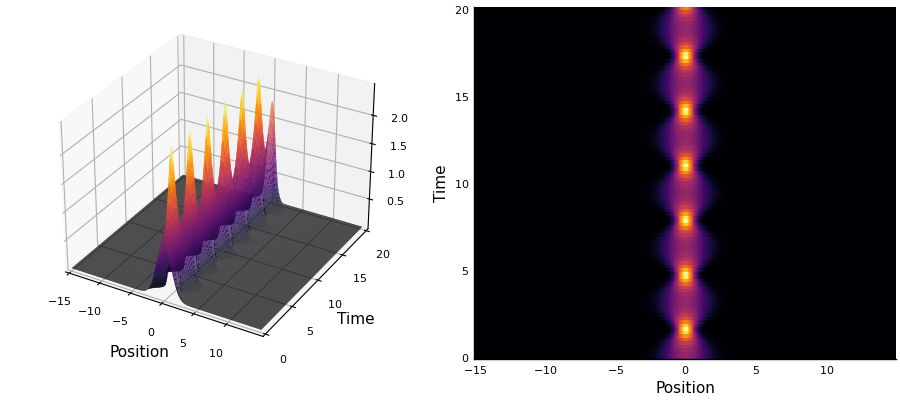

In [9]:
l = @layout [a b]
p1 = surface(x, sol.t, usol, colorbar = :none,
             xlabel = "Position", ylabel = "Time");
p2 = heatmap(x, sol.t, usol, colorbar = :none,
             xlabel = "Position", ylabel = "Time");
plot(p1, p2, layout = l,  size=(900, 400))

The POD is achieved through a singular value decomposition (SVD) of the solution.

The contribution of each mode is given by its singular value relative magnitude, as computed in `energy`.

In [10]:
U, S, Vt = svd(usol');
energy = 100 * S / sum(S);

We verify graphically and numerically that the system could be well described with only 4-5 modes, as displayed below.

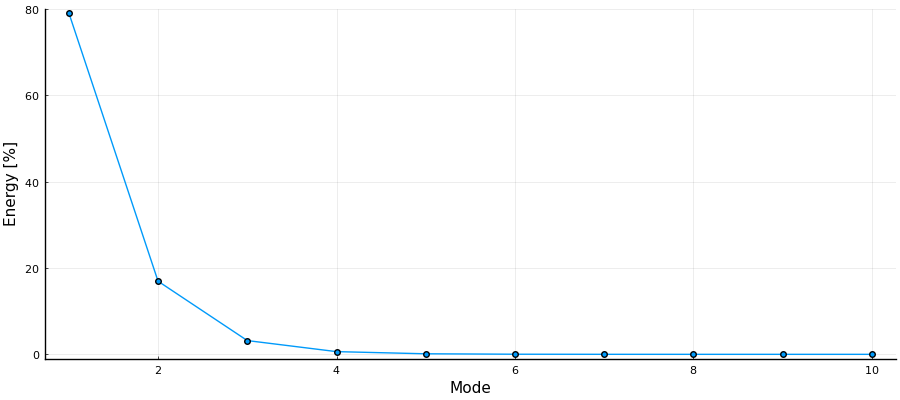

In [11]:
plot(energy[1:10], marker = :circle, legend = :none, size = (900, 400),
     xlabel = "Mode", ylabel = "Energy [%]", ylim = (-1, 80))

In [12]:
energy[1:10]

10-element Vector{Float64}:
 79.09570533146234
 16.936155975314136
  3.1862975805702836
  0.6251321669390453
  0.12480905415828183
  0.02531030997320387
  0.00519558341191854
  0.0011072356390140396
  0.00022629815792452314
  4.782079225799724e-5

The following cell provides the first three Gauss-Hermite modes and compares them to the dominant modes computed from SVD.

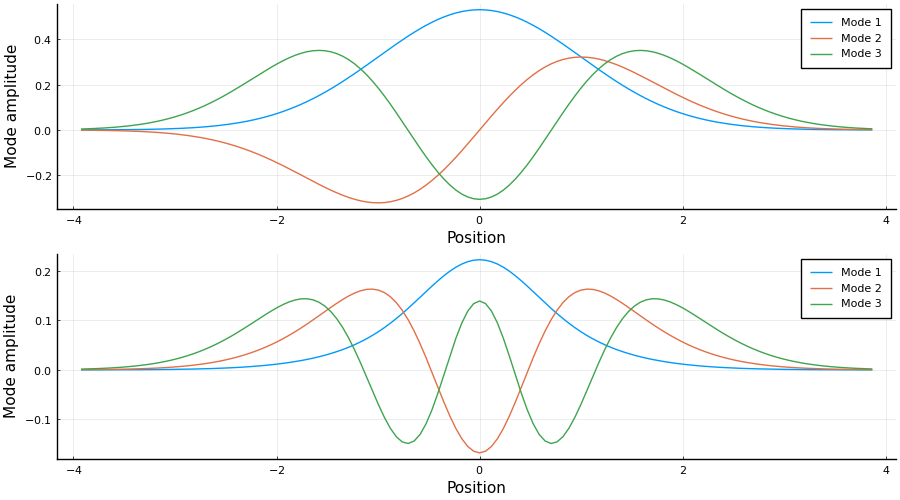

In [13]:
Ustar = -U[:, 1:3];

slice = 190:512-190+1

mult_h(x, k) = exp(-(x^2) / 2) / sqrt((2^k) * k * sqrt(pi));

v = [[mult_h(xk, 1) * basis(Hermite, 0)(xk),
      mult_h(xk, 2) * basis(Hermite, 1)(xk),
      mult_h(xk, 3) * basis(Hermite, 2)(xk)
      ] for xk in x];

Uanal = mapreduce(permutedims, vcat, v);

l = @layout [a; b]
p1 = plot(x[slice], Uanal[slice, :],
          xlabel = "Position", ylabel = "Mode amplitude",
          labels =  ["Mode 1" "Mode 2" "Mode 3"]);
p2 = plot(x[slice], Ustar[slice, :],
          xlabel = "Position", ylabel = "Mode amplitude",
          labels =  ["Mode 1" "Mode 2" "Mode 3"]);
plot(p1, p2, layout = l,  size=(900, 500))

This provides the set of basis functions used to compute the POD dynamics (which we will approach in another opportunity).